2024-12-18 11:08:25.143717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734520105.160713 3271585 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734520105.165635 3271585 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 11:08:25.186408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180371 entries, 0 to 180370
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 180371 non-null  int64  
 1   dur                180371 non-null  float64
 2   proto              180371 non-null  object 
 3   service            180371 non-null  object 
 4   state              180371 non-null  object 
 5   spkts              180371 non-null  int64  
 6   dpkts              180371 non-null  int64  
 7   sbytes             180371 non-null  int64  
 8   dbytes             180371 non-null  int64  
 9   rate               180371 non-null  float64
 10  sttl               180371 non-null  int64  
 11  dttl               180371 non-null  int64  
 12  sload              180371 non-null  float64
 13  dload              180371 non-null  float64
 14  sloss              180371 non-null  int64  
 15  dloss              180371 non-null  

/tmp/ipykernel_3271585/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


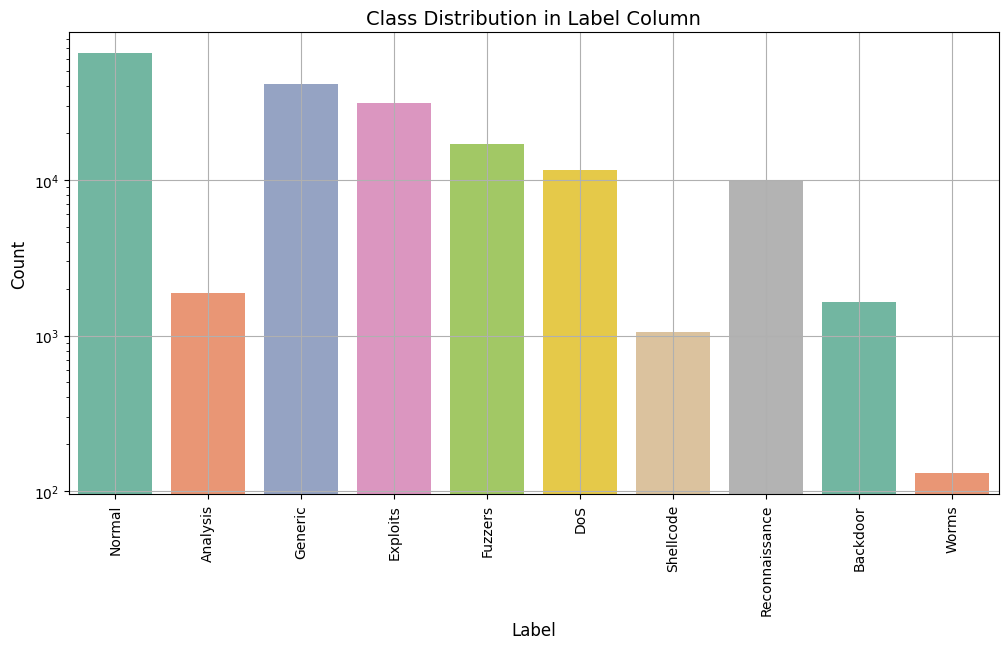

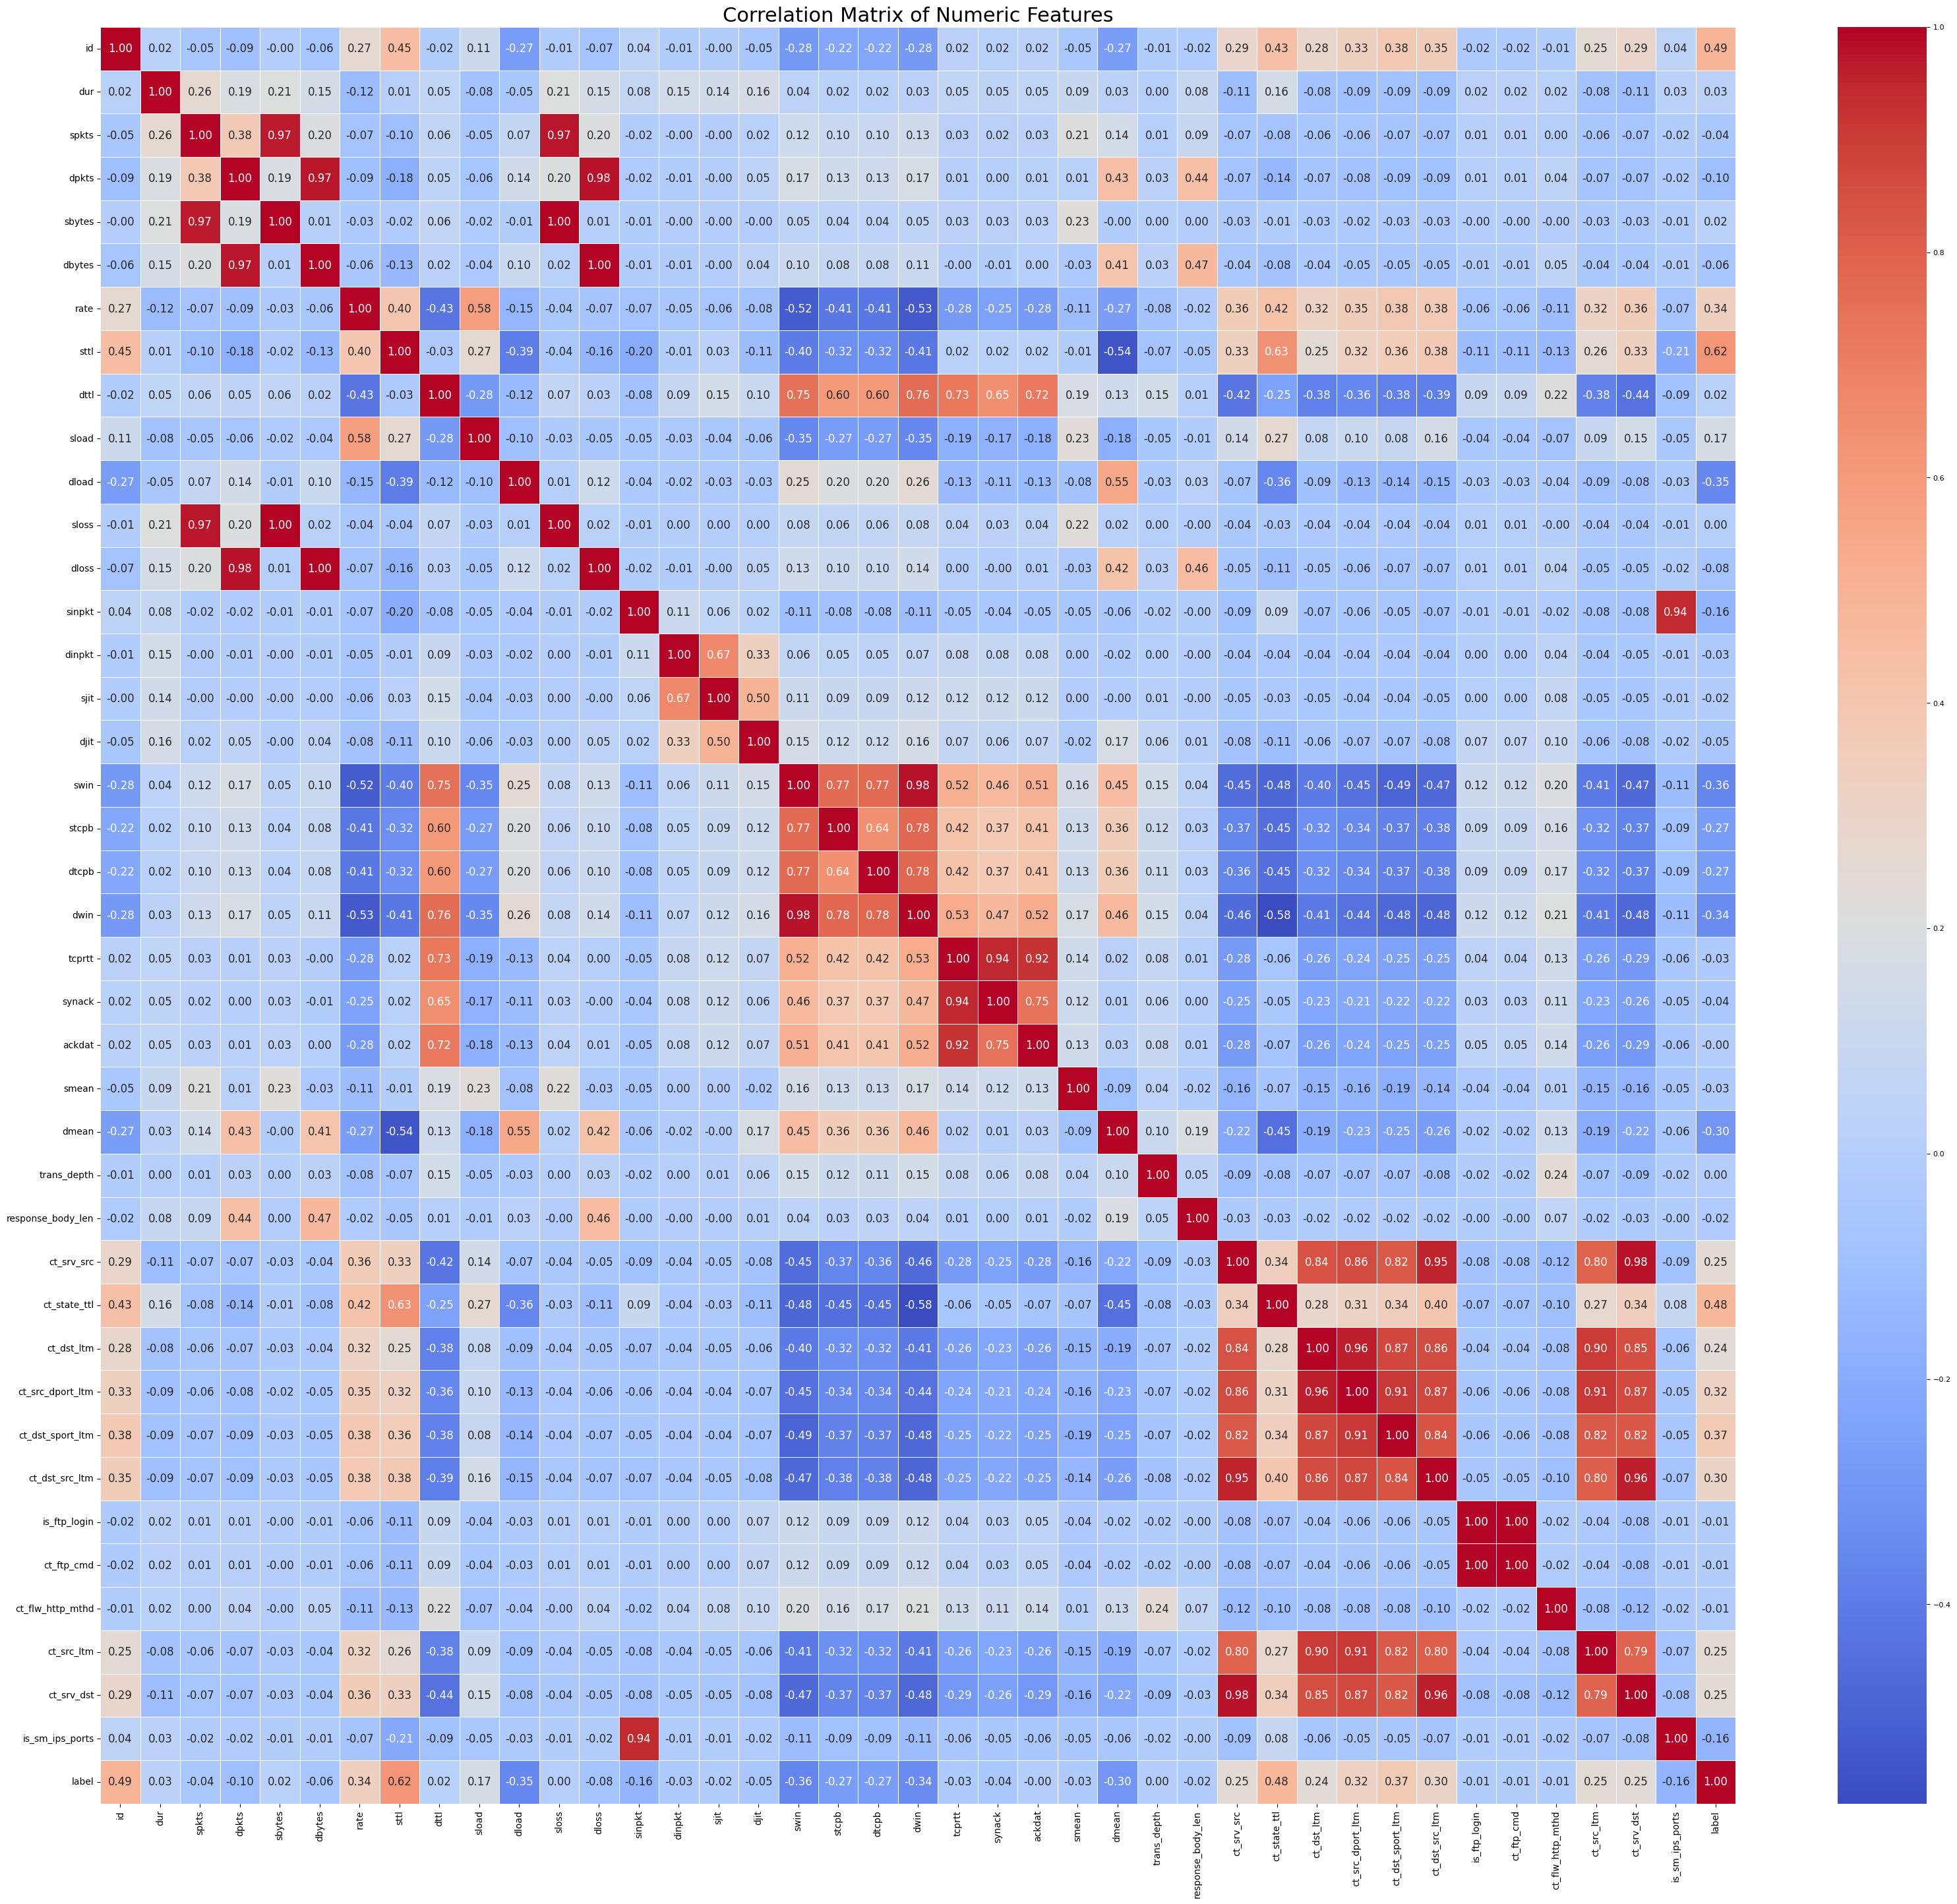

In [1]:
import import_ipynb
%run TON_IoT_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class ID_CNN(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, kernel_size=3, num_filters=64, dropout=0.5):
        super(ID_CNN, self).__init__()

        # Step 1: Convolutional Layers for feature extraction
        # First Convolutional Layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        # Second Convolutional Layer
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters * 2, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        # Third Convolutional Layer
        self.conv3 = nn.Conv1d(in_channels=num_filters * 2, out_channels=num_filters * 4, kernel_size=kernel_size, stride=1, padding=kernel_size//2)

        # Step 2: Pooling Layers (Max pooling to reduce dimensionality)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the first convolution
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the second convolution
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)  # Reduce dimensionality after the third convolution

        # Step 3: Fully connected layers (for classification)
        # Flattening the features after pooling
        self.fc1 = nn.Linear(num_filters * 4 * (input_dim // 8), hidden_dim)  # Adjust input dimension after pooling
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # Ensure input shape is [batch_size, channels, length]
        # Apply convolution layers for feature extraction
        x = self.conv1(x)  # [batch_size, num_filters, seq_len]
        x = torch.relu(x)
        x = self.pool1(x)  # Apply max pooling

        x = self.conv2(x)  # [batch_size, num_filters*2, reduced_seq_len]
        x = torch.relu(x)
        x = self.pool2(x)  # Apply max pooling

        x = self.conv3(x)  # [batch_size, num_filters*4, further_reduced_seq_len]
        x = torch.relu(x)
        x = self.pool3(x)  # Apply max pooling

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten the output

        # Apply fully connected layers
        x = torch.relu(self.fc1(x))  # [batch_size, hidden_dim]
        x = self.dropout(x)
        x = self.fc2(x)  # [batch_size, num_classes]

        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = ID_CNN(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"TON_IoT_ID_CNN_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: 357.478093, Validation Loss: 0.015734, Validation Accuracy: 0.994722, Learning Rate: 0.001000
Epoch 2, Loss: 70.789880, Validation Loss: 0.007090, Validation Accuracy: 0.998318, Learning Rate: 0.001000
Epoch 3, Loss: 40.060559, Validation Loss: 0.009460, Validation Accuracy: 0.996093, Learning Rate: 0.001000
Epoch 4, Loss: 52.999120, Validation Loss: 0.030749, Validation Accuracy: 0.992574, Learning Rate: 0.001000
Epoch 5, Loss: 39.164595, Validation Loss: 0.022840, Validation Accuracy: 0.995524, Learning Rate: 0.001000
Epoch 6, Loss: 31.293835, Validation Loss: 0.003464, Validation Accuracy: 0.999534, Learning Rate: 0.001000
Epoch 7, Loss: 38.365105, Validation Loss: 0.006099, Validation Accuracy: 0.998499, Learning Rate: 0.001000
Epoch 8, Loss: 24.581897, Validation Loss: 0.020626, Validation Accuracy: 0.996766, Learning Rate: 0.001000
Epoch 9, Loss: 14.616397, Validation Loss: 0.005428, Validation Accuracy: 0.999379, Learning Rate: 0.001000
Epoch 10, Loss: 32.545275, 

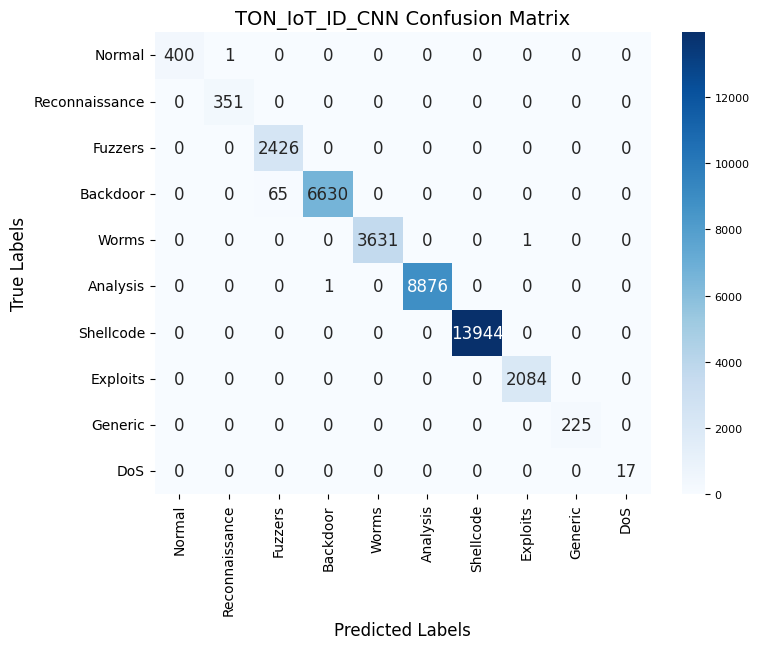

TON_IoT_ID_CNN Classification Report:
                precision    recall  f1-score   support

        Normal       1.00      1.00      1.00       401
Reconnaissance       1.00      1.00      1.00       351
       Fuzzers       0.97      1.00      0.99      2426
      Backdoor       1.00      0.99      1.00      6695
         Worms       1.00      1.00      1.00      3632
      Analysis       1.00      1.00      1.00      8877
     Shellcode       1.00      1.00      1.00     13944
      Exploits       1.00      1.00      1.00      2084
       Generic       1.00      1.00      1.00       225
           DoS       1.00      1.00      1.00        17

      accuracy                           1.00     38652
     macro avg       1.00      1.00      1.00     38652
  weighted avg       1.00      1.00      1.00     38652



In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.title("TON_IoT_ID_CNN Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("TON_IoT_ID_CNN Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
